In [1]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from gaiaxpy import generate, PhotometricSystem
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# # scalers for dataloading
# metscaler = MinMaxScaler()
# logscaler = MinMaxScaler()
# tefscaler = MinMaxScaler()
# scalerlist = [MinMaxScaler() for _ in range(110)] # Hardcoded since we know number of xp coefficients is static

# # dataloader batchlength, learning rate, epochs for training
# batchlen = 32
# lr = 1e-2
# epochs = 100

# class ResBlock(nn.Module):
#     def __init__(self, nodes):
#         super(ResBlock, self).__init__()
#         self.res_block1 = nn.Sequential(
#             nn.Linear(nodes,nodes),
#             nn.BatchNorm1d(nodes),
#             nn.LeakyReLU(),
#         )
#         self.res_block2 = nn.Sequential(
#             nn.Linear(nodes,nodes),
#             nn.BatchNorm1d(nodes),
#         )
#         self.lrelu = nn.LeakyReLU()
    
#     def forward(self, x):
#         res = x
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = x + res
#         output = self.lrelu(x)
#         return output
        
# class ResNetMcK(nn.Module):
#     def __init__(self):
#         super(ResNetMcK, self).__init__()
#         self.input_block = nn.Sequential(
#             nn.Linear(3,16),
#             nn.LeakyReLU(),
#         )
#         self.blocklist = nn.ModuleList([
#             ResBlock(16),
#             ResBlock(16),
#             nn.Linear(16,32),
#             ResBlock(32),
#             ResBlock(32),
#             nn.Linear(32,64),
#             ResBlock(64),
#             ResBlock(64),
#             nn.Linear(64,128),
#             ResBlock(128),
#             ResBlock(128),
#         ])
#         self.output_block = nn.Sequential(
#             nn.Linear(128,110),
#         )
        
#     def forward(self,x):
#         x = self.input_block(x)
#         for i, _ in enumerate(self.blocklist):
#             x = self.blocklist[i](x)
#         logits = self.output_block(x)
#         return logits
    
# # defining the Dataset class
# class train_set(Dataset):
#     def __init__(self,file):
#         fn = h5py.File(file, 'r')
#         self.f = fn
        
#         # get data
#         dset = fn['group_1']['data']
#         self.x = torch.Tensor(dset[:].T)
        
#         # get label
#         ydset = self.f['group_1']['label']
#         self.y = torch.Tensor(ydset[:].T)
#         # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
#         # get error in label # comment out for non-error label runs
#         errdset = self.f['group_1']['e_label']
#         self.err = torch.Tensor(errdset[:].T)
        
#     def __len__(self):
#         return self.f['group_1']['data'].shape[1]
  
#     def __getitem__(self, index):
#         xg = self.x[index]
#         yg = self.y[index]
#         errg = self.err[index]
#         return (xg,yg,errg)

# class valid_set(Dataset):
#     def __init__(self,file):
#         fn = h5py.File(file, 'r')
#         self.f = fn
        
#         # get data
#         dset = self.f['group_2']['data']
#         self.x = torch.Tensor(dset[:].T)
        
#         # get label
#         ydset = self.f['group_2']['label']
#         self.y = torch.Tensor(ydset[:].T)
#         # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
#         # get error in label # comment out for non-error label runs
#         errdset = self.f['group_2']['e_label']
#         self.err = torch.Tensor(errdset[:].T)
        
#     def __len__(self):
#         return self.f['group_2']['data'].shape[1]
  
#     def __getitem__(self, index):
#         xg = self.x[index]
#         yg = self.y[index]
#         errg = self.err[index]
#         return (xg,yg,errg)
    
# class new_data_set(Dataset):
#     def __init__(self,file,train=True,valid=False):
#         fn = h5py.File(file, 'r')
#         self.f = fn
        
#         # get data
#         dset = fn['group_1']['data']
#         d = dset[:]
#         dat = np.array([
#             metscaler.fit_transform(d[[0]].T).flatten(),
#             logscaler.fit_transform(d[[1]].T).flatten(),
#             tefscaler.fit_transform(d[[2]].T).flatten(),
#         ])
#         if train:
#             self.l = dat.shape[1]
#             self.x = torch.Tensor(dat.T)
#         elif valid:
#             dset = fn['group_2']['data']
#             d = dset[:]
#             dat = np.array([
#                 metscaler.transform(d[[0]].T).flatten(),
#                 logscaler.transform(d[[1]].T).flatten(),
#                 tefscaler.transform(d[[2]].T).flatten(),
#             ])
#             self.l = dat.shape[1]
#             self.x = torch.Tensor(dat.T)
        
#         # get label
#         ydset = self.f['group_1']['label']
#         yd = ydset[:]
#         ydat = np.array([
#             scaler.fit_transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
#         ])
#         if train:
#             self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
#         elif valid:
#             ydset = self.f['group_2']['label']
#             yd = ydset[:]
#             ydat = np.array([
#                 scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
#             ])
#             self.y = torch.Tensor(ydat[:].T)
        
#         # get error in label # comment out for non-error label runs
#         if train:
#             errdset = self.f['group_1']['e_label']
#             self.err = torch.Tensor(errdset[:].T)
#         elif valid:
#             errdset = self.f['group_2']['e_label']
#             self.err = torch.Tensor(errdset[:].T)
        
#     def __len__(self):
#         return self.l
  
#     def __getitem__(self, index):
#         xg = self.x[index]
#         yg = self.y[index]
#         errg = self.err[index]
#         return (xg,yg,errg)

In [4]:
# scalers for dataloading
metscaler = MinMaxScaler()
logscaler = MinMaxScaler()
tefscaler = MinMaxScaler()
amscaler = MinMaxScaler()
scalerlist = [MinMaxScaler() for _ in range(110)] # Hardcoded since we know number of xp coefficients is static

scale = 'MinMax'
batchlen = 32
lr = 1e-2
epochs = 2
optimize = 'SGD'
datafname = '/arc/home/aydanmckay/input_catalogue_simple_average_datacuts.h5'
lossname = 'L2'
# datafname = '/arc/home/aydanmckay/input_catalogue_datacuts.h5'

In [5]:
class new_data_set(Dataset):
    def __init__(self,file,train=True,valid=False,test=False,noscale=False):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = fn['group_1']['data']
        d = dset[:]
        dat = np.array([
            metscaler.fit_transform(d[[0]].T).flatten(),
            logscaler.fit_transform(d[[1]].T).flatten(),
            tefscaler.fit_transform(d[[2]].T).flatten(),
            # amscaler.fit_transform(d[[3]].T).flatten(), # comment out if not
        ])
        if train:
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif valid:
            dset = fn['group_2']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                # amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif test:
            dset = fn['group_3']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                # amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
            self.x = dat.T
        elif noscale:
            dset = fn['group_3']['data']
            d = dset[:]
            self.l = d.shape[1]
            self.x = torch.Tensor(d.T)
            self.x = d.T
        
        # get label
        ydset = self.f['group_1']['label']
        yd = ydset[:]
        ydat = np.array([
            scaler.fit_transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
        ])
        if train:
            self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        elif valid:
            ydset = self.f['group_2']['label']
            yd = ydset[:]
            ydat = np.array([
                scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
            ])
            self.y = torch.Tensor(ydat[:].T)
        elif test:
            ydset = self.f['group_3']['label']
            yd = ydset[:]
            ydat = np.array([
                scaler.transform(yd[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
            ])
            self.y = torch.Tensor(ydat[:].T)
        elif noscale:
            ydset = self.f['group_3']['label']
            yd = ydset[:]
            self.y = torch.Tensor(yd.T)
        
        # get error in label # comment out for non-error label runs
        if train:
            errdset = self.f['group_1']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif valid:
            errdset = self.f['group_2']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif test or noscale:
            errdset = self.f['group_3']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.l
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)
    
class ResBlock(nn.Module):
    def __init__(self, nodes):
        super(ResBlock, self).__init__()
        self.res_block1 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
            nn.LeakyReLU(),
        )
        self.res_block2 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
        )
        self.lrelu = nn.LeakyReLU()
#         add dropout in the init
        self.do = nn.Dropout() #
    
    def forward(self, x):
        res = x
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x + res
        output = self.lrelu(x)
#         add dropout after the relu
        output = self.do(x) #
        return output
        
class ResNetMcK(nn.Module):
    def __init__(self):
        super(ResNetMcK, self).__init__()
        self.input_block = nn.Sequential(
            nn.Linear(3,16),
            nn.LeakyReLU(),
        )
        self.blocklist = nn.ModuleList([
            ResBlock(16),
            ResBlock(16),
            nn.Linear(16,32),
            ResBlock(32),
            ResBlock(32),
            nn.Linear(32,64),
            ResBlock(64),
            ResBlock(64),
            nn.Linear(64,128),
            ResBlock(128),
            ResBlock(128),
        ])
        self.output_block = nn.Sequential(
            nn.Linear(128,110),
        )
        
    def forward(self,x):
        x = self.input_block(x)
        for i, _ in enumerate(self.blocklist):
            x = self.blocklist[i](x)
        logits = self.output_block(x)
        return logits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 110),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# try 3-layer simple network with sigmoid

In [6]:
# # training_data = train_set("/arc/home/aydanmckay/mydataelabelssmallscalecuts.h5")
# # data = valid_set("/arc/home/aydanmckay/smallcutdataMinMaxscaled.h5")
# # training_data = new_data_set('/arc/home/aydanmckay/smallcutdata.h5',train=True,valid=False)
# valid_data = new_data_set('/arc/home/aydanmckay/smallcutdata.h5',train=False,valid=True)
# loaded_data = DataLoader(
#     valid_data,
#     batch_size=32,
#     num_workers=0
#     # shuffle=True
# )

In [7]:
test_data = new_data_set(datafname,train=False,test=True)
loaded_data = DataLoader(
    test_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)
unscaled_data = new_data_set(datafname,train=False,noscale=True)
unscaled_dataloader = DataLoader(
    unscaled_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)

In [8]:
scales = []
noscales = []
with torch.no_grad():
    for (X, y, z), (X2, y2, z2) in zip(loaded_data,unscaled_data):
        for scaled,noscaled in zip(y,y2):
            # print(scaled)
            scales.append(scaled)
            noscales.append(noscaled)

In [11]:
len(noscales)

276047

In [12]:
np.shape(scales)

/arc/home/aydanmckay/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/arc/home/aydanmckay/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(276047,)

In [7]:
model = ResNetMcK()
model.load_state_dict(torch.load("/arc/home/aydanmckay/torchresmodel/modelL2smallminmaxscalecutsbl32lr-2wd-5SGDep100new.pth"))
# model.eval()

<All keys matched successfully>

In [8]:
model = model.to(device)

In [9]:
preds = []
covbs = []
covrs = []
with torch.no_grad():
    for X, y, z in loaded_data:
        X = X.to(device)
        y = y.to(device)
        z = z.to(device)
        pred = model(X)
        for prediction,err in zip(pred,z):
            covbp = np.zeros((55,55))
            covrp = np.zeros((55,55))
            preds.append(prediction)
            for it in range(len(err[:55])):
                covbp[it][it] += err[it].item()**2
                covrp[it][it] += err[it+55].item()**2
            covbs.append(covbp)
            covrs.append(covrp)

In [10]:
np.array(covrs).shape

(10000, 55, 55)

(5000, 55, 55)

In [11]:
# phot_system_list = [
#     PhotometricSystem.Gaia_2,
#     PhotometricSystem.Gaia_DR3_Vega,
#     PhotometricSystem.PanSTARRS1,
#     PhotometricSystem.PanSTARRS1_Std,
#     PhotometricSystem.Pristine,
#     PhotometricSystem.SDSS,
#     PhotometricSystem.SDSS_Std
# ]

In [12]:
# df = pd.DataFrame(
#     {'source_id':range(len(preds)),
#      'bp_coefficients':[pred.to('cpu').numpy()[:55] for pred in preds],
#      'bp_standard_deviation':[np.std(pred.to('cpu').numpy()[:55]) for pred in preds],
#      'bp_coefficient_covariances':covbs,
#      'rp_coefficients':[pred.to('cpu').numpy()[55:] for pred in preds],
#      'rp_coefficient_covariances':covrs,
#      'rp_standard_deviation':[np.std(pred.to('cpu').numpy()[55:]) for pred in preds]
#     }
# )

In [13]:
# df

In [14]:
f = "select TOP 1 source_id from gaiadr3.gaia_source where source_id = '4486317061229025280'"

In [15]:
synthetic_photometry = generate(f, photometric_system=PhotometricSystem.Pristine)
# synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
# synthetic_photometry

INFO: Query finished. [astroquery.utils.tap.core]


In [16]:
synthetic_photometry

,source_id,Pristine_mag_CaHK,Pristine_flux_CaHK,Pristine_flux_error_CaHK
0,4486317061229025280,18.390889,3.205711e-18,2.908615e-19


In [17]:
# PhotometricSystem.get_available_systems()

In [18]:
preds = np.array([pred.to('cpu').numpy() for pred in preds]).T

In [19]:
preds.shape

(110, 10000)

(110, 5000)

In [20]:
# rpnewpred = []
xpnewpred = []
for pred,scaler in zip(preds,scalerlist):
    xpnewpred.append(scaler.inverse_transform(np.array([pred]).T).flatten())

In [21]:
bpnews = np.array(xpnewpred[:55]).T
rpnews = np.array(xpnewpred[55:]).T
rpnews.shape

(10000, 55)

(5000, 55)

In [22]:
bpnews.shape

(10000, 55)

(5000, 55)

In [23]:
len(preds.T)

10000

5000

In [24]:
dfnew = pd.DataFrame(
    {'source_id':range(len(preds.T)),
     'bp_coefficients':list(bpnews),
     'bp_standard_deviation':[np.std(bp) for bp in bpnews],
     'bp_coefficient_covariances':covbs,
     'rp_coefficients':list(rpnews),
     'rp_coefficient_covariances':covrs,
     'rp_standard_deviation':[np.std(rp) for rp in rpnews]
    }
)

In [25]:
dfnew

,source_id,bp_coefficients,bp_standard_deviation,bp_coefficient_covariances,rp_coefficients,rp_coefficient_covariances,rp_standard_deviation
0,0,"[-5905.6226, -1215.184, 1559.697, -313.47748, ...",846.757812,"[[1.3530883679632097, 0.0, 0.0, 0.0, 0.0, 0.0,...","[25110.87, 279.11584, -1814.1895, 376.4323, 39...","[[1.1188093113034938, 0.0, 0.0, 0.0, 0.0, 0.0,...",3373.192871
1,1,"[3543.8823, -6340.8555, -541.6055, -489.0615, ...",1066.301514,"[[19.642633873536397, 0.0, 0.0, 0.0, 0.0, 0.0,...","[53649.625, 17997.78, -2144.7546, 1298.442, 74...","[[5.241453255338456, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7529.217285
2,2,"[-18121.795, -14873.444, -4684.9556, 85.684074...",3205.214844,"[[10.414952383322088, 0.0, 0.0, 0.0, 0.0, 0.0,...","[22770.793, -34523.12, 2959.793, -4993.6235, -...","[[3.9151179899335062, 0.0, 0.0, 0.0, 0.0, 0.0,...",5632.783203
3,3,"[74228.78, -63193.508, 11874.315, -11346.983, ...",13356.910156,"[[24.14848358416043, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9087.588, -9726.781, -13977.768, -9820.643, ...","[[6.402672176555143, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2913.840820
4,4,"[63526.473, 7293.811, -2686.6008, -2493.1125, ...",8549.365234,"[[39.53359646402532, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[51949.1, 15222.029, 3457.7043, 696.895, -436....","[[9.302246653374425, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7198.860840
...,...,...,...,...,...,...,...
9995,9995,"[-43774.258, -16060.549, -5608.4014, 261.2793,...",6205.309570,"[[1.5814655857644198, 0.0, 0.0, 0.0, 0.0, 0.0,...","[81333.85, -16514.398, 868.03937, 2071.5874, -...","[[0.6920138775812212, 0.0, 0.0, 0.0, 0.0, 0.0,...",11138.761719
9996,9996,"[-36239.164, 19862.447, -68.03998, -1044.1726,...",5578.966797,"[[49.99674966231487, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23858.613, 9060.119, -2028.4557, 3508.6978, -...","[[13.394225427033746, 0.0, 0.0, 0.0, 0.0, 0.0,...",3442.674072
9997,9997,"[-1181.7491, -8527.546, -671.3713, 556.43445, ...",1160.019897,"[[2.182061821133189, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[31380.875, 10094.56, -2253.3164, 3487.9404, -...","[[0.9831897800609681, 0.0, 0.0, 0.0, 0.0, 0.0,...",4421.782227
9998,9998,"[371.5981, 16171.61, -4141.5454, 1050.4727, -5...",2264.471680,"[[0.31816607356086024, 0.0, 0.0, 0.0, 0.0, 0.0...","[-45958.836, 8950.568, 2978.9514, 4108.747, -8...","[[0.18097798081726157, 0.0, 0.0, 0.0, 0.0, 0.0...",6324.713379


In [26]:
synthetic_photometry = generate(dfnew, photometric_system=PhotometricSystem.Pristine)
synthetic_photometry

,source_id,Pristine_mag_CaHK,Pristine_flux_CaHK,Pristine_flux_error_CaHK
0,0,14.463028,1.194178e-16,4.910124e-16
1,1,12.523589,7.125977e-16,2.345415e-15
2,2,NaN,-6.654155e-16,5.142384e-15
3,3,9.932576,7.749071e-15,3.137539e-14
4,4,12.546494,6.977217e-16,3.005030e-14
...,...,...,...,...
9995,9995,NaN,-5.727967e-16,4.368852e-15
9996,9996,NaN,-1.886638e-15,1.816834e-14
9997,9997,13.008219,4.560290e-16,9.928421e-16
9998,9998,NaN,-1.285963e-15,1.046627e-15


In [27]:
synthetic_photometry.describe()

,source_id,Pristine_mag_CaHK,Pristine_flux_CaHK,Pristine_flux_error_CaHK
count,10000.00000,5645.000000,1.000000e+04,1.000000e+04
mean,4999.50000,12.570289,2.599149e-16,7.971491e-15
std,2886.89568,1.353390,1.823737e-15,1.168975e-14
min,0.00000,8.329516,-1.177966e-14,9.130998e-17
25%,2499.75000,11.714833,-5.501543e-16,2.064881e-15
50%,4999.50000,12.414171,1.622733e-16,4.263972e-15
75%,7499.25000,13.251829,9.133238e-16,9.048648e-15
max,9999.00000,20.545167,3.392138e-14,1.909764e-13


In [28]:
# max(synthetic_pho)

NameError: name 'synthetic_pho' is not defined

## Cleaning the Dataset

In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import h5py
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [3]:
data = Table.read('/arc/home/aydanmckay/input_catalogue_simple_average_datacuts.fits').to_pandas()

In [4]:
data.shape

(6756683, 224)

In [5]:
data['Teff'].describe()

count    3.187680e+06
mean     5.576873e+03
std      9.254797e+02
min      2.000061e+03
25%      4.925000e+03
50%      5.551740e+03
75%      6.003603e+03
max      2.968421e+04
Name: Teff, dtype: float64

In [6]:
with pd.option_context('mode.use_inf_as_na', True):
    data.dropna(inplace=True)
data.shape

(3185660, 224)

In [7]:
labels = ["bp_1", "bp_2", "bp_3", "bp_4", "bp_5", "bp_6", "bp_7",
          "bp_8", "bp_9", "bp_10", "bp_11", "bp_12", "bp_13", "bp_14",
          "bp_15", "bp_16", "bp_17", "bp_18", "bp_19", "bp_20", "bp_21",
          "bp_22", "bp_23", "bp_24", "bp_25", "bp_26", "bp_27", "bp_28",
          "bp_29", "bp_30", "bp_31", "bp_32", "bp_33", "bp_34", "bp_35",
          "bp_36", "bp_37", "bp_38", "bp_39", "bp_40", "bp_41", "bp_42",
          "bp_43", "bp_44", "bp_45", "bp_46", "bp_47", "bp_48", "bp_49",
          "bp_50", "bp_51", "bp_52", "bp_53", "bp_54", "bp_55", "rp_1",
          "rp_2", "rp_3", "rp_4", "rp_5", "rp_6", "rp_7", "rp_8",
          "rp_9", "rp_10", "rp_11", "rp_12", "rp_13", "rp_14", "rp_15",
          "rp_16", "rp_17", "rp_18", "rp_19", "rp_20", "rp_21", "rp_22",
          "rp_23", "rp_24", "rp_25", "rp_26", "rp_27", "rp_28", "rp_29",
          "rp_30", "rp_31", "rp_32", "rp_33", "rp_34", "rp_35", "rp_36",
          "rp_37", "rp_38", "rp_39", "rp_40", "rp_41", "rp_42", "rp_43",
          "rp_44", "rp_45", "rp_46", "rp_47", "rp_48", "rp_49", "rp_50",
          "rp_51", "rp_52", "rp_53", "rp_54", "rp_55"]
elabels = ["bpe_1", "bpe_2", "bpe_3", "bpe_4", "bpe_5", "bpe_6", "bpe_7",
          "bpe_8", "bpe_9", "bpe_10", "bpe_11", "bpe_12", "bpe_13", "bpe_14",
          "bpe_15", "bpe_16", "bpe_17", "bpe_18", "bpe_19", "bpe_20", "bpe_21",
          "bpe_22", "bpe_23", "bpe_24", "bpe_25", "bpe_26", "bpe_27", "bpe_28",
          "bpe_29", "bpe_30", "bpe_31", "bpe_32", "bpe_33", "bpe_34", "bpe_35",
          "bpe_36", "bpe_37", "bpe_38", "bpe_39", "bpe_40", "bpe_41", "bpe_42",
          "bpe_43", "bpe_44", "bpe_45", "bpe_46", "bpe_47", "bpe_48", "bpe_49",
          "bpe_50", "bpe_51", "bpe_52", "bpe_53", "bpe_54", "bpe_55", "rpe_1",
          "rpe_2", "rpe_3", "rpe_4", "rpe_5", "rpe_6", "rpe_7", "rpe_8",
          "rpe_9", "rpe_10", "rpe_11", "rpe_12", "rpe_13", "rpe_14", "rpe_15",
          "rpe_16", "rpe_17", "rpe_18", "rpe_19", "rpe_20", "rpe_21", "rpe_22",
          "rpe_23", "rpe_24", "rpe_25", "rpe_26", "rpe_27", "rpe_28", "rpe_29",
          "rpe_30", "rpe_31", "rpe_32", "rpe_33", "rpe_34", "rpe_35", "rpe_36",
          "rpe_37", "rpe_38", "rpe_39", "rpe_40", "rpe_41", "rpe_42", "rpe_43",
          "rpe_44", "rpe_45", "rpe_46", "rpe_47", "rpe_48", "rpe_49", "rpe_50",
          "rpe_51", "rpe_52", "rpe_53", "rpe_54", "rpe_55"]

In [8]:
for label in elabels:
    data = data[(data[label] < 10) & (data[label] > -10)]
data.shape

(2760468, 224)

In [9]:
data.describe()

,Source,Teff,Fe/H,log_g,bp_1,bp_2,bp_3,bp_4,bp_5,bp_6,...,rpe_46,rpe_47,rpe_48,rpe_49,rpe_50,rpe_51,rpe_52,rpe_53,rpe_54,rpe_55
count,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,...,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06,2.760468e+06
mean,1.354867e+18,5.559839e+03,-3.047135e-01,3.956259e+00,3.081158e+03,-3.142178e+02,-4.649970e+01,1.017612e+01,-1.458162e+01,-2.401143e-01,...,5.481881e-01,4.597329e-01,4.614236e-01,4.215364e-01,4.208722e-01,3.755934e-01,3.253556e-01,2.922394e-01,1.209549e-01,6.283754e-02
std,1.375249e+18,8.749845e+02,4.000597e-01,7.839472e-01,3.753270e+03,6.744630e+02,1.294352e+02,4.501367e+01,2.864284e+01,3.383810e+01,...,3.724654e-01,3.350996e-01,3.157487e-01,2.867222e-01,2.830562e-01,2.593105e-01,2.351276e-01,2.125289e-01,8.153095e-02,4.395291e-02
min,1.275606e+12,2.000061e+03,-4.487347e+00,1.022424e-01,-4.954706e-01,-1.158789e+04,-1.718666e+03,-1.205797e+03,-4.306089e+02,-4.856790e+02,...,7.365149e-02,7.936749e-02,5.036612e-02,5.157712e-02,5.979707e-02,4.697054e-02,4.695595e-02,4.460493e-02,2.037394e-02,1.122545e-02
25%,3.633004e+17,4.942549e+03,-4.803064e-01,3.748853e+00,5.008719e+02,-4.151244e+02,-6.100787e+01,-1.954040e+00,-2.091621e+01,-8.224856e+00,...,2.848472e-01,2.404903e-01,2.252530e-01,2.094404e-01,2.186622e-01,1.851985e-01,1.645335e-01,1.491396e-01,6.983764e-02,3.768071e-02
50%,8.513440e+17,5.544362e+03,-2.458427e-01,4.185440e+00,1.548965e+03,-9.261651e+01,-1.484639e+01,3.209242e+00,-6.181377e+00,-8.639159e-01,...,4.303732e-01,3.592551e-01,3.700105e-01,3.351032e-01,3.334721e-01,2.997078e-01,2.559782e-01,2.291866e-01,9.526259e-02,4.943595e-02
75%,1.890435e+18,5.974675e+03,-5.855548e-02,4.470944e+00,4.164026e+03,-5.177086e+00,-2.172130e-01,1.842319e+01,-9.847219e-01,5.993603e+00,...,6.969030e-01,5.726636e-01,6.083570e-01,5.503203e-01,5.376198e-01,4.903553e-01,4.130568e-01,3.683050e-01,1.450107e-01,7.325711e-02
max,6.917529e+18,2.945512e+04,4.591588e+00,5.980000e+00,3.692985e+04,5.510930e+03,2.606343e+03,6.267605e+02,6.271200e+02,9.009338e+02,...,6.935789e+00,6.231711e+00,3.908607e+00,3.928383e+00,4.231868e+00,3.302374e+00,4.092391e+00,3.842599e+00,1.664967e+00,2.041306e+00


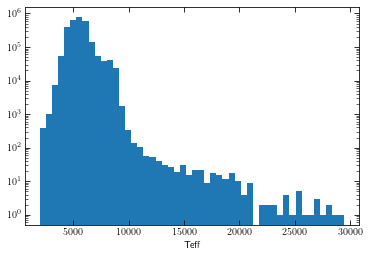

In [10]:
plt.hist(data['Teff'],bins=50,log=True);
plt.xlabel('Teff');

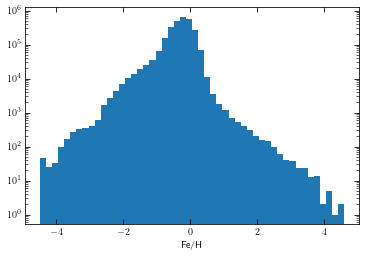

In [11]:
plt.hist(data['Fe/H'],bins=50,log=True);
plt.xlabel('Fe/H');

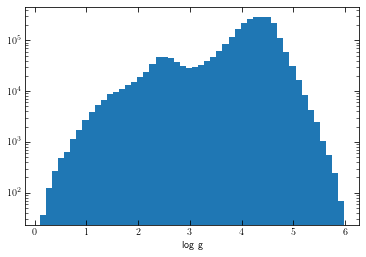

In [12]:
plt.hist(data['log_g'],bins=50,log=True)
plt.xlabel('log g');

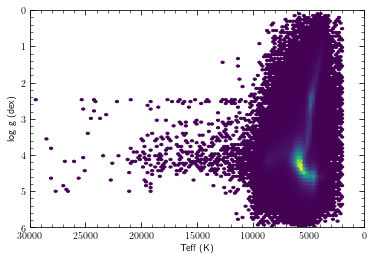

In [13]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(1000))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.hexbin(data['Teff'],data['log_g'],mincnt=1)
plt.xlim(30000,0);plt.ylim(6,0);
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/hexbindata.png')

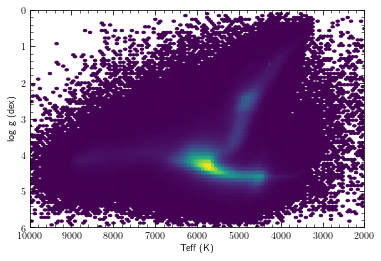

In [14]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.hexbin(data['Teff'][data['Teff'] < 10000],data['log_g'][data['Teff'] < 10000],mincnt=1)
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.xlim(10000,2000);plt.ylim(6,0);

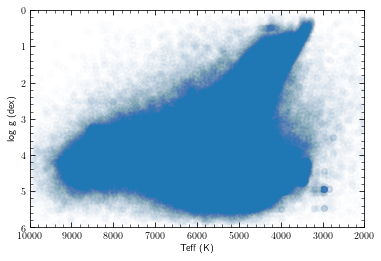

In [15]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(data['Teff'][data['Teff'] < 10000],data['log_g'][data['Teff'] < 10000],alpha=0.01)
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.xlim(10000,2000);plt.ylim(6,0);

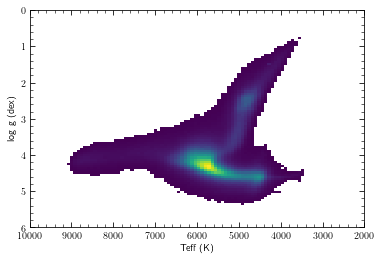

In [16]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

h = plt.hist2d(data['Teff'][data['Teff'] < 10000],data['log_g'][data['Teff'] < 10000],bins=100,cmin=100)
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.xlim(10000,2000);plt.ylim(6,0);

In [17]:
data['log_g'][data['Teff'] > 10000] *= np.nan
data['Teff'][data['Teff'] > 10000] *= np.nan
for i in range(len(h[0][0])):
    for j in range(len(h[0][0])):
        if np.isnan(h[0][i][j]) or h[0][i][j] == 1.:
            data[(data['Teff'] >= h[1][i]) & (data['Teff'] <= h[1][i+1]) & (data['log_g'] >= h[2][j]) & (data['log_g'] <= h[2][j+1])] *= np.nan
            # continue
        # print(i,j)
    print(i)

/tmp/ipykernel_4213/1126459005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_g'][data['Teff'] > 10000] *= np.nan
/tmp/ipykernel_4213/1126459005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Teff'][data['Teff'] > 10000] *= np.nan


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [18]:
data.describe()

,Source,Teff,Fe/H,log_g,bp_1,bp_2,bp_3,bp_4,bp_5,bp_6,...,rpe_46,rpe_47,rpe_48,rpe_49,rpe_50,rpe_51,rpe_52,rpe_53,rpe_54,rpe_55
count,2.682219e+06,2.681433e+06,2.682219e+06,2.681433e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,...,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06,2.682219e+06
mean,1.351461e+18,5.546035e+03,-3.000421e-01,3.969936e+00,3.113714e+03,-3.183485e+02,-4.740819e+01,1.068877e+01,-1.487185e+01,-5.375756e-01,...,5.498134e-01,4.604103e-01,4.629267e-01,4.229596e-01,4.219684e-01,3.765686e-01,3.259322e-01,2.926867e-01,1.211535e-01,6.290972e-02
std,1.371780e+18,8.169841e+02,3.831210e-01,7.550998e-01,3.765433e+03,6.740856e+02,1.293590e+02,4.478552e+01,2.862737e+01,3.370769e+01,...,3.711257e-01,3.329442e-01,3.140532e-01,2.853907e-01,2.815865e-01,2.576782e-01,2.335232e-01,2.110315e-01,8.119288e-02,4.373329e-02
min,1.275606e+12,3.439595e+03,-4.487347e+00,7.490956e-01,2.832256e-01,-1.158789e+04,-1.718666e+03,-1.150163e+03,-3.607251e+02,-4.856790e+02,...,7.365149e-02,7.936749e-02,5.036612e-02,5.157712e-02,5.979707e-02,4.697054e-02,4.695595e-02,4.460493e-02,2.037394e-02,1.122545e-02
25%,3.638841e+17,4.949711e+03,-4.746255e-01,3.777219e+00,5.169034e+02,-4.222742e+02,-6.206029e+01,-1.795162e+00,-2.129777e+01,-8.518698e+00,...,2.867781e-01,2.419620e-01,2.273667e-01,2.112264e-01,2.201500e-01,1.867957e-01,1.657138e-01,1.501373e-01,7.013765e-02,3.779534e-02
50%,8.514924e+17,5.540424e+03,-2.440411e-01,4.189994e+00,1.585159e+03,-9.580362e+01,-1.538792e+01,3.425675e+00,-6.436154e+00,-9.667317e-01,...,4.331532e-01,3.611529e-01,3.726194e-01,3.374985e-01,3.355100e-01,3.016334e-01,2.574194e-01,2.304260e-01,9.567341e-02,4.960389e-02
75%,1.886502e+18,5.960428e+03,-5.920461e-02,4.468626e+00,4.211853e+03,-6.168601e+00,-4.894555e-01,1.896615e+01,-1.074456e+00,5.849769e+00,...,6.993301e-01,5.739192e-01,6.104327e-01,5.523270e-01,5.392164e-01,4.918147e-01,4.140189e-01,3.691120e-01,1.453844e-01,7.343186e-02
max,6.917529e+18,9.115372e+03,4.550797e+00,5.392057e+00,3.692985e+04,5.510930e+03,2.594202e+03,6.267605e+02,6.271200e+02,9.009338e+02,...,6.935789e+00,6.231711e+00,3.908607e+00,3.928383e+00,4.231868e+00,3.302374e+00,4.092391e+00,3.842599e+00,1.664967e+00,2.041306e+00


In [19]:
with pd.option_context('mode.use_inf_as_na', True):
    data.dropna(inplace=True)
data.shape

(2681433, 224)

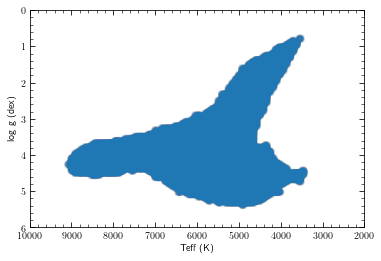

In [20]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(data['Teff'],data['log_g'],alpha=0.01)
plt.xlim(10000,2000);plt.ylim(6,0);
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/scattercleandata.png')

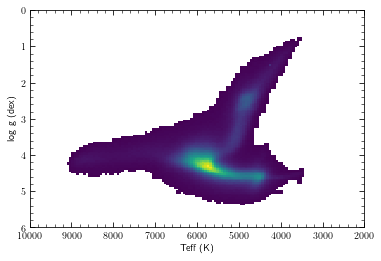

In [21]:
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(.2))

h = plt.hist2d(
    data['Teff'],
    data['log_g'],
    bins=100,
    cmin=1
)
plt.xlim(10000,2000);plt.ylim(6,0);
plt.xlabel('Teff (K)')
plt.ylabel('log g (dex)')
plt.savefig('/arc/home/aydanmckay/meetingplots/hist2dcleandata.png')

In [ ]:
feh = data['Fe/H']
teff = data['Teff']
logg = data['log_g']
xp = []
xpe = []
for elabel,label in zip(elabels,labels):
    xp.append(data[label])
    xpe.append(data[elabel])
xp = np.array(xp)
xpe = np.array(xpe)

In [ ]:
xp.T.shape

In [ ]:
feh_train, feh_test, teff_train, teff_test, logg_train, logg_test, xp_train, xp_test, xpe_train, xpe_test = train_test_split(
    feh,
    teff,
    logg,
    xp.T,
    xpe.T,
    test_size=0.1,
    random_state=42
)

In [ ]:
feh_train, feh_valid, teff_train, teff_valid, logg_train, logg_valid, xp_train, xp_valid, xpe_train, xpe_valid = train_test_split(
    feh_train,
    teff_train,
    logg_train,
    xp_train,
    xpe_train,
    test_size=0.1,
    random_state=42
)

In [ ]:
# Create a HDF5 file
hierarchicalFileName  = "/arc/home/aydanmckay/input_catalogue_simple_average_hugedatacuts.h5"
with h5py.File(hierarchicalFileName, 'w') as hierarchicalFile:
    # Create a group under root
    train = hierarchicalFile.create_group("group_1")
    valid = hierarchicalFile.create_group("group_2")
    test = hierarchicalFile.create_group("group_3")
    
    train['data'] = np.array(
        [feh_train,
         logg_train,
         teff_train,
        ]
    )
    valid['data'] = np.array(
        [feh_valid,
         logg_valid,
         teff_valid,
        ]
    )
    test['data'] = np.array(
        [feh_test,
         logg_test,
         teff_test,
        ]
    )
    train['label'] = xp_train.T
    train['e_label'] = xpe_train.T
    valid['label'] = xp_valid.T
    valid['e_label'] = xpe_valid.T
    test['label'] = xp_test.T
    test['e_label'] = xpe_test.T

    print(hierarchicalFile["/"])
    print(train)
    print(valid)
    print(train['data'])
    print(valid["label"])
    print(test['e_label'])

In [ ]:
scalerlist = [MinMaxScaler() for _ in range(110)]
with h5py.File("/arc/home/aydanmckay/input_catalogue_simple_average_hugedatacuts.h5", 'r') as f:
    d = f['group_1']['label']
    dset = d[:]
    ydat = np.array([
        scaler.fit_transform(d[[it]].T).flatten() for it,scaler in enumerate(scalerlist)
    ])
    print(ydat.shape[1])
    print(f['group_1']['label'].shape[1])
    print(f['group_1']['data'].shape)

In [ ]:
dset.shape

In [ ]:
dset

In [ ]:
ydat